The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6


# ナイーブベイズ分類

複雑な最適化アルゴリズムやGPUについて心配する前に、最初の分類器として、シンプルな統計的指標と条件付き独立を利用した分類器をデプロイしてみましょう。学習というものは、仮定を置くことにほかなりません。見たことのない新しいデータを分類するためには、互いに*類似*しているデータに関して仮定を置く必要があります。

最も利用されている (そして非常にシンプルな) アルゴリズムはナイーブベイズ分類器でしょう。分類のタスクを自然に表すとすれば、「その特徴から、最も可能性のあるラベルはなんですか?」という確率を考えた質問になるでしょう。数式で表すと、予測$\hat{y}$は以下の式で与えられるでしょう。

$$\hat{y} = \text{argmax}_y \> p(y | \mathbf{x})$$

残念ながら、これはすべての値 $\mathbf{x} = x_1, ..., x_d$に対して $p(y | \mathbf{x})$ を予測する必要があります。各特徴が2値のうちの1つをとる場合を考えてみましょう。例えば、特徴$x_1 = 1$が「りんご」がある文書に現れていることを、$x_1 = 0$は現れないことを表すとしましょう。$30$個の2値の特徴があれば、それは$2^{30}$、つまり10億以上の値をとりうる入力ベクトル$\mathbf{x}$を分類する必要があります。

さらに、学習はどうやって行うでしょうか? 対応するラベルを予測するために、すべての起こりうる値を見なければならないのであれば、パターンを学習しているとはいえず、それはデータセットを記憶しているに過ぎません。幸運にも条件付き独立に関するいくつかの仮定を置くことによって、帰納的な性質を設けることができ、学習データからそこまで多くないデータを選んで、一般化するようなモデルを作ることができます。

始めるにあたって、ベイズの定理を利用して、以下のように分類器を表現しましょう。

$$\hat{y} = \text{argmax}_y \> \frac{p( \mathbf{x} | y) p(y)}{p(\mathbf{x})}$$

分母は正規化項$p(\mathbf{x})$でラベル$y$の値に依存しません。結果として、異なる$y$の値に対して、分子を比較することだけ考えれば良いです。たとえ、分母を計算することが非常に難しいことがわかっても、それを無視することができ、分子を評価するだけで良いです。幸運にも、正規化するための定数を計算したい場合は、$\sum_y p(y | \mathbf{x}) = 1$ということがわかっているので、その項をいつでも計算することができます。確率のチェインルールを利用することで、$p( \mathbf{x} | y)$の項は以下のように表現することができます。

$$p(x_1 |y) \cdot p(x_2 | x_1, y) \cdot ... \cdot p( x_d | x_1, ..., x_{d-1} y)$$

この式自体では、まだ何も進んでいません。まだ、大雑把に言って、$2^d$のパラメータを予測しなければならないからです。しかし、*ラベルに対して各特徴が互いに条件付き独立である*仮定を置くことによって、$\prod_i p(x_i | y)$という単純な形式に変換できます。予測式は以下のようになります。

$$ \hat{y} = \text{argmax}_y \> = \prod_i p(x_i | y) p(y)$$

$\prod_i p(x_i | y)$ の各項を予測することは、たった1つのパラメータを予測することと同じになりました。条件付き独立の仮定は、特徴の数に応じた指数的な依存関係を線形な関係へと変換し、パラメータ数の観点から複雑さを解消しました。さらに、以前見たことのないデータに対して予測行うこともできます。なぜなら、$p(x_i | y)$を求めればよいだけで、これをたくさんの異なる文書にもとづいて予測することができるからです。

ラベルが与えられたとき、特徴が互いにすべて独立であるという重要な仮定、つまり$p(\mathbf{x} | y) = \prod_i p(x_i | y)$についてより詳しく見てみましょう。Eメールをスパムかそうでないかに分類することを考えます。`ナイジェリア`、`王子`、`金`、`リッチ`といった単語が現れればは、おそらくスパムの可能性があり、一方`理論`、`ネットワーク`,
`ベイズ`、`統計学`という単語が現れれば、それは口座番号を聞き出す巧みな試みと関係ないものと考えられるでしょう。そこで、それぞれのクラスに対して各単語の起こりうる確率をモデル化し、文章の尤もらしさをスコア化しましょう。実際のところ、これはいわゆる[ベイズのパムフィルタ](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering)として、長い間にわたって機能してきました。

## 光学文字認識 (OCR; Optical Character Recognition)

画像はとても扱いやすいので、MNISTデータセットの数字を分類するナイーブベイズ分類器の動作について説明しましょう。問題は、$p(y)$ and $p(x_i | y)$についてわかっていないことです。そこでまず、学習データから、それを*推定*する必要があります。これをモデルを*学習する*と言います。$p(y)$を推定することはそこまで難しくありません。10クラスだけを扱っているので非常に簡単です。各数字の発生回数$n_y$を計算し、データの総数$n$で割るだけです。例えば、数字8が$n_8 = 5,800$回現れて、全体で$n = 60,000$画像あるとすれば、その確率は$p(y=8) = 0.0967$として推定されます。

ここで、少しむずかしいこと、$p(x_i | y)$について考えましょう。白黒の画像を取り出すので、$p(x_i | y)$はピクセル$i$がクラス$y$によって値が1になる確率を表しています。ちょうど上で行ったように、発生した回数$n_{iy}$を数えて、$y$の全発生回数$n_y$で割ることができます。しかし、ちょっとした問題がここで生じます。それは、あるピクセルにおいて黒にならないピクセルがあることです (もしうまく切り取られた画像であれば、画像の隅であっても白になる可能性はありますが)。この問題に対処するための統計学者にとって便利な方法は、擬似的なカウントを全カウントに加えることです。従って、$n_{iy}$ではなく$n_{iy}+1$を利用し、$n_y$の代わりに$n_y+1$を利用します。これは[Laplace Smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)と呼ばれています。

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import mxnet as mx
from mxnet import nd
import numpy as np

# 1回で1つだけ観測しましょう（ここでは時間を気にしません)
def transform(data, label):
    return (nd.floor(data/128)).astype(np.float32), label.astype(np.float32)
mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test  = mx.gluon.data.vision.MNIST(train=False, transform=transform)

# カウンターを初期化
xcount = nd.ones((784,10))
ycount = nd.ones((10))

for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:,y] += data.reshape((784))

# 割るために Broadcastを使いましょう
py = ycount / ycount.sum()
px = (xcount / ycount.reshape(1,10))

In [2]:
for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:,y] += data.reshape((784))

ここで、すべてのピクセルに対して、ピクセルごとの発生回数をカウントしたため、モデルがどのように動くのかを確認することができます。プロットしてみましょう。これが画像に対して作業をする上でとても便利なところなのです。28x28x10の確率 (つまり各クラス、各ピクセルごと) を可視化することは、通常無駄な作業でしょう。しかし、それらを画像としてプロットすると、全体像を手早く理解することができます。察しの良い読者の方はおそらく、数字を見ることに意味があることに気づいているかと思いますが…

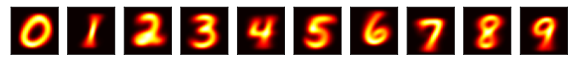

Class probabilities 
[0.09871688 0.11236461 0.09930012 0.10218297 0.09736711 0.09035161
 0.09863356 0.10441593 0.09751708 0.09915014]
<NDArray 10 @cpu(0)>


In [3]:
import matplotlib.pyplot as plt
fig, figarr = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    figarr[i].imshow(xcount[:, i].reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[i].axes.get_xaxis().set_visible(False)
    figarr[i].axes.get_yaxis().set_visible(False)

plt.show()
print('Class probabilities', py)

ここでモデルに対して、画像の尤もらしさを計算することができます。これは$p(x | y)$について統計学者の言いたいことを代弁しています。つまり、ある条件下 (つまりラベル) が与えられたときに、特定の画像見る可能性を表しています。ナイーブベイズモデルでは、すべてのピクセルは独立であり、以下を想定しています。

$$p(\mathbf{x} | y) = \prod_{i} p(x_i | y)$$

ベイズの法則を使うことで、$p(y | \mathbf{x})$ を計算できます。

$$p(y | \mathbf{x}) = \frac{p(\mathbf{x} | y) p(y)}{\sum_{y'} p(\mathbf{x} | y')}$$

やってみましょう。

In [4]:
# 最初のテストデータを取り出します
data, label = mnist_test[0]
data = data.reshape((784,1))

# ピクセルごとの条件付き確率を計算します
xprob = (px * data + (1-px) * (1-data))
# 掛け算
xprob = xprob.prod(0) * py
print('Unnormalized Probabilities', xprob)
# 正規化
xprob = xprob / xprob.sum()
print('Normalized Probabilities', xprob)

Unnormalized Probabilities 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<NDArray 10 @cpu(0)>
Normalized Probabilities 
[nan nan nan nan nan nan nan nan nan nan]
<NDArray 10 @cpu(0)>


これは、ひどく間違っています！なぜか考えてみましょう。ピクセルごとの確率を見てみます。それらは$0.001$から$1$の間の数値をとっています。それらに$784$を掛けてみます。これらの値はコンピュータで計算されているので、指数に対する固定の範囲があります。つまり*数値のアンダーフロー*が発生していたわけです。つまり小さい値をすべて掛け合わせると、さらに小さくなって、ゼロに丸められてしまいます。そして、ゼロによる割り算が発生して`nan`という結果が出てしまいます。

これを修正するために、$\log a b = \log a + \log b$という事実を利用します。つまり対数をとってから足し合わせます。これは対数空間における正規化されていない確率を与えるでしょう。そこで正規化するためには以下を利用します。

$$\frac{\exp(a)}{\exp(a) + \exp(b)} = \frac{\exp(a + c)}{\exp(a + c) + \exp(b + c)}$$

特に$c = -\max(a,b)$を利用することができ、これは分母の項が少なくとも1つは1になることを保証します。

/var/lib/jenkins/miniconda3/envs/d2l-en-0/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


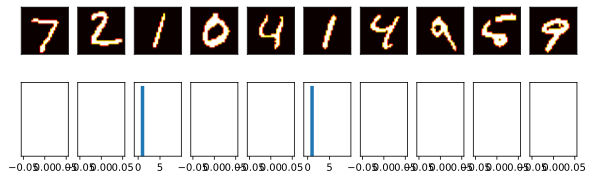

In [5]:
logpx = nd.log(px)
logpxneg = nd.log(1-px)
logpy = nd.log(py)

def bayespost(data):
    # p(y|x)は p(x|y) p(y)似比例するので、
    # 確率 p(y) の事前分布を計算します
    logpost = logpy.copy()
    logpost += (logpx * data + logpxneg * (1-data)).sum(0)
    # 最大値を引くことで、オーバーフロー、アンダーフローを回避  logpost -= nd.max(logpost)
    # logpx を使って softmaxを計算します
    post = nd.exp(logpost).asnumpy()
    post /= np.sum(post)
    return post

fig, figarr = plt.subplots(2, 10, figsize=(10, 3))

# 画像を10個表示
ctr = 0
for data, label in mnist_test:
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)

    # Bar chart and image of digit
    figarr[1, ctr].bar(range(10), post)
    figarr[1, ctr].axes.get_yaxis().set_visible(False)
    figarr[0, ctr].imshow(x.reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[0, ctr].axes.get_xaxis().set_visible(False)
    figarr[0, ctr].axes.get_yaxis().set_visible(False)
    ctr += 1

    if ctr == 10:
        break

plt.show()

確認できたように、この分類器は多くの場合において有効です。しかし、2番めの最後の数字からは、分類機はうまく動いておらず、誤った推定に対して大きな確信度を示していることを確認できます。たとえ、ひどく間違っていたとしても、その確率は1や0に近い値を出力します。現在においては、多用すべき分類器とはいえないでしょう。全体に対してどのような性能を示すか、分類器の全体の精度を計算しましょう。

In [6]:
# カウンター初期化
ctr = 0
err = 0

for data, label in mnist_test:
    ctr += 1
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)
    if (post[y] < post.max()):
        err += 1

print('Naive Bayes has an error rate of', err/ctr)

/var/lib/jenkins/miniconda3/envs/d2l-en-0/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Naive Bayes has an error rate of 0.0004


現代のディープニューラルネットワークでは、誤り率は0.01未満です。ナイーブベイズ分類器は、特にスパムフィルタリングの用途で80年代、90年代に利用されていて、最盛期は終わっています。性能が良くない理由は、誤った統計的仮定をモデルにおいたからです。その仮定とは、ピクセル間は独立であり、ラベルにのみ依存するというものです。これは、人間が数字を書くところを考えれば明らかに誤っていると考えられ、誤った仮定はナイーブベイズ分類器の性能を非常に悪化させます。そこで、ディープニューラルネットワークを構築するときがきました。

## まとめ

* ナイーブベイズは以下の仮定を利用した簡単に利用できる分類器です。
  $p(\mathbf{x} | y) = \prod_i p(x_i | y)$.
* 分類器の学習は簡単ですが推定をひどく誤る可能性があります。
* 過大な信頼度をもっていたり、理にかなわない推定に対しては、 確率 $p(x_i|y)$に対して平滑化、例えば、Laplace
smoothingを行います。つまり、すべてのカウントに対して定数を加えます。
* ナイーブベイズ分類器は観測に対する相関を利用しません。

## 練習

1. $p(x_i | y)$が正規分布となるナイーブベイズ回帰を設計しましょう。
1. どのような状況であれば、ナイーブベイズは上手く働きますか?
1. 目撃者は犯人を再度目撃したとき、90%の精度で認識できます。
   * 被疑者が5人であれば、これはうまくいくでしょうか?
   * 被疑者が50人でもうまくいきますか?

## [議論](https://discuss.mxnet.io/t/2320)のためのQRコードをスキャン

![](../img/qr_naive-bayes.svg)